In [1]:
%matplotlib inline


Audio Data Augmentation
=================

``torchaudio`` provides a variety of ways to augment audio data.


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio

import torch
import torchaudio
import torchaudio.functional as F
import audiomentations
import librosa

print(torch.__version__)
print(torchaudio.__version__)

1.8.1+cu111
0.8.1


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [3]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

Applying effects and filtering
------------------------------

``torchaudio.sox_effects`` allows for directly applying filters similar to
those available in ``sox`` to Tensor objects and file object audio sources.

There are two functions for this:

-  ``torchaudio.sox_effects.apply_effects_tensor`` for applying effects
   to Tensor.
-  ``torchaudio.sox_effects.apply_effects_file`` for applying effects to
   other audio sources.

Both functions accept effect definitions in the form
``List[List[str]]``.
This is mostly consistent with how ``sox`` command works, but one caveat is
that ``sox`` adds some effects automatically, whereas ``torchaudio``’s
implementation does not.

For the list of available effects, please refer to `the sox
documentation <http://sox.sourceforge.net/sox.html>`__.

**Tip** If you need to load and resample your audio data on the fly,
then you can use ``torchaudio.sox_effects.apply_effects_file`` with
effect ``"rate"``.

**Note** ``apply_effects_file`` accepts a file-like object or path-like
object. Similar to ``torchaudio.load``, when the audio format cannot be
inferred from either the file extension or header, you can provide
argument ``format`` to specify the format of the audio source.

**Note** This process is not differentiable.




In [4]:
%cd ../
!ls -la

/home/stealth/MMVC_Trainer
total 500
drwxr-xr-x 16 stealth stealth   4096 Jun 16 17:46 .
drwxr-xr-x 26 stealth stealth   4096 Jun 16 16:56 ..
drwxr-xr-x  8 stealth stealth   4096 Jun 16 18:53 .git
-rw-r--r--  1 stealth stealth   1828 May 20 18:46 .gitignore
drwxr-xr-x  2 stealth stealth   4096 May 20 19:45 .ipynb_checkpoints
drwxr-xr-x  2 stealth stealth   4096 Jun 16 17:46 .vscode
-rw-r--r--  1 stealth stealth   2138 Apr 28 19:49 LICENSE
-rw-r--r--  1 stealth stealth   9765 May 13 13:35 README.md
drwxr-xr-x  2 stealth stealth   4096 Jun 16 17:49 __pycache__
-rw-r--r--  1 stealth stealth  11780 Apr 28 19:49 attentions.py
-rw-r--r--  1 stealth stealth   4778 Apr 28 19:49 commons.py
drwxr-xr-x  2 stealth stealth   4096 Jun 16 17:46 configs
-rw-r--r--  1 stealth stealth   8365 Apr 28 19:49 create_dataset_jtalk.py
-rw-r--r--  1 stealth stealth   3230 Apr 28 19:49 create_dataset_julius.py
-rw-r--r--  1 stealth stealth  19707 Jun 16 17:46 data_utils.py
drwxr-xr-x  4 stealth stealth   4096 Ju

In [5]:
import torchaudio

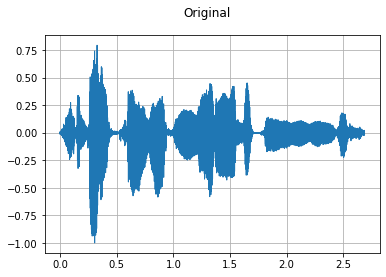

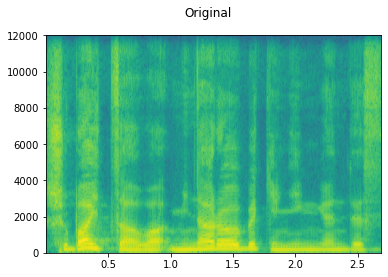

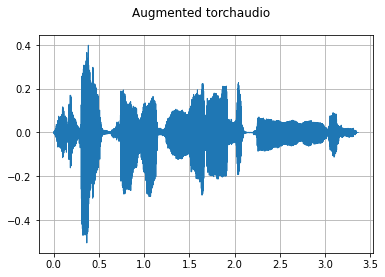

/home/stealth/anaconda3/envs/mmvcwsl/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


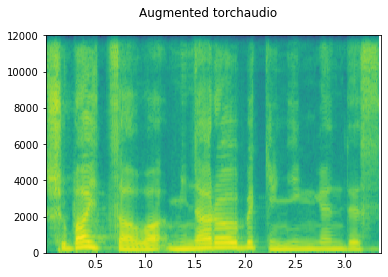

Shape of spectrogram: torch.Size([257, 631])
masked hape of spectrogram: torch.Size([257, 631])


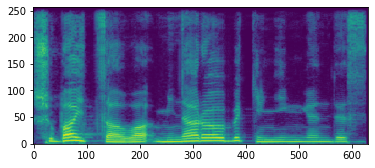

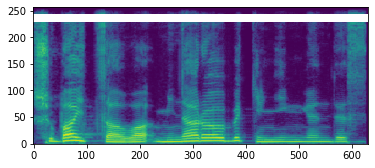

In [11]:
sampling_rate = 24000

import numpy as np
from scipy.io.wavfile import read
import random

def load_wav_to_torch(full_path):
  sampling_rate, data = read(full_path)
  return torch.FloatTensor(data.astype(np.float32)), sampling_rate

hann_window = {}

def spectrogram_torch(y, n_fft, sampling_rate, hop_size, win_size, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global hann_window
    dtype_device = str(y.dtype) + '_' + str(y.device)
    wnsize_dtype_device = str(win_size) + '_' + dtype_device
    if wnsize_dtype_device not in hann_window:
        hann_window[wnsize_dtype_device] = torch.hann_window(win_size).to(dtype=y.dtype, device=y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)

    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-6)
    return spec

augmentation_effects = [
    ['delay', '128s'],
    ['gain', '-6'],
    ["tempo", "0.8"],
    ["pitch", "400"],
    ["rate", f"{sampling_rate}"]
]

def add_augmentation(audio, sampling_rate):
    global augmentation_effects
    audio_augmented, _ = torchaudio.sox_effects.apply_effects_tensor(audio, sampling_rate, augmentation_effects)
    return audio_augmented

def add_noise(audio, sampling_rate):
    # AddGaussianNoise
    noised_audio = add_gaussian_noise(audio)
    return noised_audio

def add_gaussian_noise(audio):
    #amplitude = random.uniform(0.001, 0.004)
    amplitude = random.uniform(0.0, 0.0)
    noise = torch.randn(audio.size())
    noised_audio = audio + amplitude * noise
    return noised_audio

def add_spectrogram_noise(spec):
    # FrequencyMask
    masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
    masked = masking(spec)
    return masked

max_wav_value = 32768
def get_normalized_audio(audio, max_wav_value):
    audio_norm = audio / max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    return audio_norm

def plot_specgram2(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

#effects = [
#  ["lowpass", "-1", "300"], # ローパスフィルター(単極)の適用
#  ["speed", "0.8"],  # 速度を下げる
#  ["rate", f"{sampling_rate}"],
#  ["reverb", "-w"],  # 反響のエフェクトを加えるとドラマチックな雰囲気になる
#]

SOURCE_WAVFILE = "dataset/textful/00_myvoice/wav/emotion002.wav"

speech_torch, sr = load_wav_to_torch(SOURCE_WAVFILE)

#    audio_augmented = self.add_augumentation(audio, sampling_rate)
#    audio_noised = self.add_noise(audio_augmented, sampling_rate)
#    audio_augmented = np.clip(audio_augmented, -self.max_wav_value, self.max_wav_value)
#    audio_noised = np.clip(audio_noised, -self.max_wav_value, self.max_wav_value)
#    audio_augmented_norm = self.get_normalized_audio(audio_augmented, self.max_wav_value)
#    audio_noised_norm = self.get_normalized_audio(audio_noised, self.max_wav_value)
#    audio = audio_augmented_norm
#    spec = spectrogram_torch(audio_noised_norm, self.filter_length,
#        self.sampling_rate, self.hop_length, self.win_length,
#        center=False)
#    spec_noised = self.add_spectrogram_noise(spec)
#    spec = torch.squeeze(spec_noised, 0)

#    else:
audio_norm = get_normalized_audio(speech_torch, max_wav_value) # plotとかすんのには余計に１次元でくるんでやる必要がある
audio_augmented = add_augmentation(audio_norm, sampling_rate)
audio_noised = add_noise(audio_augmented, sampling_rate)
audio_augmented = torch.clamp(audio_augmented, -1, 1) 
audio_noised = torch.clamp(audio_noised, -1, 1)

plot_waveform(audio_norm, sr, title="Original", ylim=None)
plot_specgram(audio_norm, sr, title="Original")
play_audio(audio_norm, sr)

plot_waveform(audio_noised, sr, title="Augmented torchaudio", ylim=None)
plot_specgram(audio_noised, sr, title="Augmented torchaudio")
play_audio(audio_noised, sr)

# スペクトログラム
spec = spectrogram_torch(audio_noised, 512, sampling_rate, 128, 512, center=False)
spec = torch.squeeze(spec, 0)

print("Shape of spectrogram: {}".format(spec.size()))
plt.figure()
p = plt.imshow(spec.log2().numpy(), origin='lower')

masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

print("masked hape of spectrogram: {}".format(spec.size()))
plt.figure()
p = plt.imshow(spec.log2().numpy(), origin='lower')


In [17]:
test = random.randint(0, 100)
print(f"{test}")

26


Shape of spectrogram: torch.Size([257, 504])


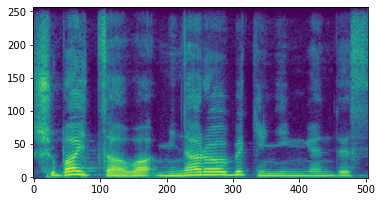

In [15]:
SOURCE_WAVFILE = "dataset/textful/00_myvoice/wav/emotion002.wav"
speech_torch, sr = load_wav_to_torch(SOURCE_WAVFILE)
audio = get_normalized_audio(speech_torch, max_wav_value) # plotとかすんのには余計に１次元でくるんでやる必要がある

# スペクトログラム
spec = spectrogram_torch(audio, 512, sampling_rate, 128, 512, center=False)
spec = torch.squeeze(spec, 0)

print("Shape of spectrogram: {}".format(spec.size()))
plt.figure()
p = plt.imshow(spec.log2().numpy(), origin='lower')

spec->split
torch.Size([257, 448])
split->spec
torch.Size([257, 448])
overlap split->spec
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 64])
torch.Size([257, 448])
ol diff
tensor([[ 7.4757e-03,  9.2874e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.5265e-03, -7.3986e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.8374e-03,  5.9727e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.0699e-03, -7.6878e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0592e-03, -9.7546e-06,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0851e-03, -1.2931e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 

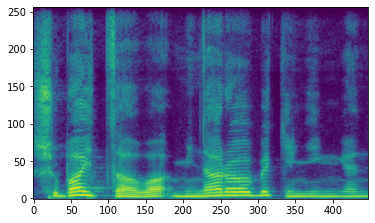

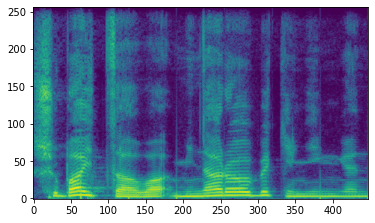

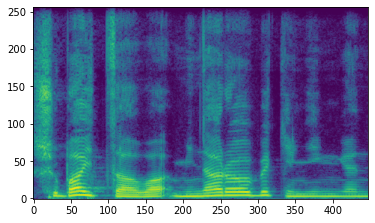

In [257]:
audio_frames = audio.unfold(1, 8192, 8192)
audio_width = audio.size()[1]
padded_audio = torch.zeros(1, audio_width + 256) # 前の win_length / 2 ぶん増やす
padded_audio[:,256:] = audio
ol_audio_frames = padded_audio.unfold(1, 8192+512, 8192) # 前後の win_length / 2 ぶん切り出す量を増やす
spec_frames = spec.unfold(1, 64, 64).transpose(0, 1)

# spec -> split (origin)
print("spec->split")
plt.figure()
for i in range(0,7):
    spec_frame = spec_frames[i]
#    print(spec_frame)
#    plt.subplot(1, 4, i+1)
#    plt.imshow(spec_frame.log2().numpy(), origin='lower')

cated_spec = None
for i in range(0,7):
    if cated_spec == None:
        cated_spec = spec_frames[i]
    else:
        cated_spec = torch.cat((cated_spec, spec_frames[i]), 1)
cated_spec = cated_spec.squeeze(0)
print(cated_spec.size())
plt.imshow(cated_spec.log2().numpy(), origin='lower')

# split -> spec (realtime conv)
print("split->spec")
specs = {}
plt.figure()
for i in range(0,7):
    specs[i] = spectrogram_torch(audio_frames[0][i].unsqueeze(0), 512, sampling_rate, 128, 512, center=False)
    spec_frame = torch.squeeze(specs[i], 0)
#    print(spec_frame)
#    plt.subplot(1, 4, i+1)
#    plt.imshow(spec_frame.log2().numpy(), origin='lower')

cated_spec = None
for i in range(0,7):
    if cated_spec == None:
        cated_spec = specs[i]
    else:
        cated_spec = torch.cat((cated_spec, specs[i]), 2)
cated_spec = cated_spec.squeeze(0)
print(cated_spec.size())
plt.imshow(cated_spec.log2().numpy(), origin='lower')

# diff
#print("diff")
#plt.figure()
for i in range(0,7):
    diff = (spec_frames[i] - torch.squeeze(specs[i], 0))
#    print(diff)
#    ax = plt.subplot(1, 4, i+1)
#    plt.imshow(diff.log2().numpy(), origin='lower')

# overlap split -> spec (realtime conv)
print("overlap split->spec")
specs = {}
plt.figure()
for i in range(0,7):
    specs[i] = spectrogram_torch(ol_audio_frames[0][i].unsqueeze(0), 512, sampling_rate, 128, 512, center=False)
    specs[i] = specs[i][:, :, 2:66] # 頭と終わりの2個づつ捨てる
    spec_frame = torch.squeeze(specs[i], 0)
#    print(spec_frame)
    print(spec_frame.size())
#    plt.subplot(1, 4, i+1)
#    plt.imshow(spec_frame.log2().numpy(), origin='lower')

cated_spec = None
for i in range(0,7):
    if cated_spec == None:
        cated_spec = specs[i]
    else:
        cated_spec = torch.cat((cated_spec, specs[i]), 2)
cated_spec = cated_spec.squeeze(0)
print(cated_spec.size())
plt.imshow(cated_spec.log2().numpy(), origin='lower')

# ol diff
print("ol diff")
#plt.figure()
for i in range(0,7):
    diff = (spec_frames[i] - torch.squeeze(specs[i], 0))
    print(diff)
#    ax = plt.subplot(1, 4, i+1)
#    plt.imshow(diff.log2().numpy(), origin='lower')


In [254]:
x1 = torch.arange(0., 10).unsqueeze(0)
x2 = torch.arange(10., 20).unsqueeze(0)
x3 = torch.arange(20., 30).unsqueeze(0)
x4 = torch.arange(30., 40).unsqueeze(0)
#print(x1, x2)
xcat = torch.cat((x1, x2, x3, x4), 0)
print(xcat)
xtest = xcat[:, 1:8]
print(xtest)

frame_width = 2
spec_height = xcat.size()[0]
spec_width = xcat.size()[1]
print(spec_width)
padded_spec_width = spec_width + frame_width - spec_width % frame_width
print(padded_spec_width)
frame_size = padded_spec_width // frame_width
padded_spec = torch.zeros(spec_height, padded_spec_width)
print(padded_spec.size())
padded_spec[:, :spec_width] = xcat
print(padded_spec)

spec_frames = padded_spec.reshape(frame_size, spec_height, frame_width)
print(spec_frames)

xcat.unfold(1, 3, 3)
#xtuple = xcat.split(2, dim=0)
#for x in xtuple:
#    x = x.unsqueeze(0)
#    print(x)
#xsplits = torch.cat(xtuple, -1)
#print(xsplits)
#xtuple
#torch.cat((xtuple[0].unsqueeze(0), xtuple[1].unsqueeze(0)), 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.],
        [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.],
        [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.]])
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [11., 12., 13., 14., 15., 16., 17.],
        [21., 22., 23., 24., 25., 26., 27.],
        [31., 32., 33., 34., 35., 36., 37.]])
10
12
torch.Size([4, 12])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  0.,  0.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,  0.,  0.],
        [20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,  0.,  0.],
        [30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,  0.,  0.]])
tensor([[[ 0.,  1.],
         [ 2.,  3.],
         [ 4.,  5.],
         [ 6.,  7.]],

        [[ 8.,  9.],
         [ 0.,  0.],
         [10., 11.],
         [12., 13.]],

        [[14., 15.],
         [16., 17.],
         [18., 19.],
         [ 0.,  0.]],

        [[20.

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.]],

        [[10., 11., 12.],
         [13., 14., 15.],
         [16., 17., 18.]],

        [[20., 21., 22.],
         [23., 24., 25.],
         [26., 27., 28.]],

        [[30., 31., 32.],
         [33., 34., 35.],
         [36., 37., 38.]]])

In [1]:
import math

bytes1 = b'abcdefg'
bytes2 = b'tuvwxyz'
bytes3 = bytes1 + bytes2
bytes4 = bytes3[4:8]
bytes4

b'efgt'

In [268]:
bytescat = bytes1+bytes2
bytestail = bytescat[-3:]
bytestail

b'xyz'

リアルタイム音声変換でファイルから入力する場合のモック作成

In [144]:
class MockStream:
    def __init__(self, input_filename, output_filename):
        self.fr = open(input_filename, 'rb')
        self.fw = open(output_filename, 'wb')
        
    def read(self, length, exception_on_overflow=False):
        wav = self.fr.read(length)
        if len(wav) <= 0:
            raise ValueError("End of data.")
        return wav

    def write(self, wav):
        self.fw.write(wav)
    
test_stream = MockStream("testinput.wav", "testoutput.wav")

Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 32])
Shape of spectrogram: torch.Size([257, 24])
Stop Streaming: ValueError('End of data.')


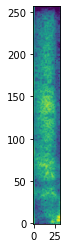

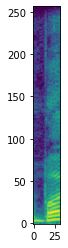

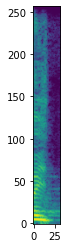

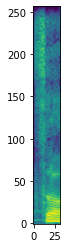

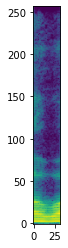

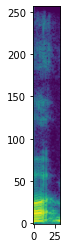

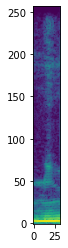

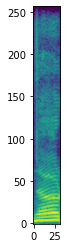

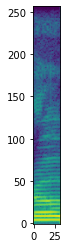

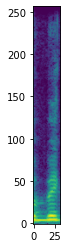

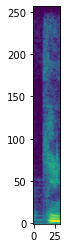

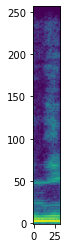

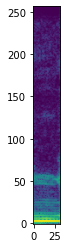

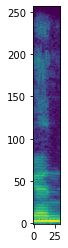

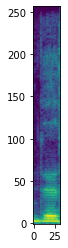

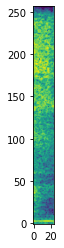

In [145]:
try:
    for i in range(100):
        wav = test_stream.read(8192)
        test_stream.write(wav)

        signal = np.frombuffer(wav, dtype='int16')
        wav_torch = torch.FloatTensor(signal.astype(np.float32))
        audio = get_normalized_audio(wav_torch, max_wav_value)
        spec = spectrogram_torch(audio, 512, sampling_rate, 128, 512, center=False)
        spec = torch.squeeze(spec, 0)

        print("Shape of spectrogram: {}".format(spec.size()))
        plt.figure()
        p = plt.imshow(spec.log2().numpy(), origin='lower')
except Exception as e:
    print("Stop Streaming: " +  repr(e))

In [162]:
class TestA:
    def __init__(self):
        self.test1 = None
        self.test2 = None
        
    def test(self):
        if 'test1' in locals():
            print("test1 in")
        if 'test3' in locals():
            print("test3 in ")

a = TestA()
a.test1 = "testa1"
a.test2 = "testa2"

a.test()

In [160]:
if hasattr(a, "test1"):
    print("OK")
else:
    print("NO")

OK


In [82]:
# Load the data
waveform1, sample_rate1 = get_sample(resample=16000)

# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ['gain', '+20'],  # normalises to 0dB
  ['pitch', '-50'],  # 5 cent pitch shift
  ["speed", "1.0"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform1, sample_rate1, effects)

plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")

NameError: name 'get_sample' is not defined

Note that the number of frames and number of channels are different from
those of the original after the effects are applied. Let’s listen to the
audio. Doesn’t it sound more dramatic?




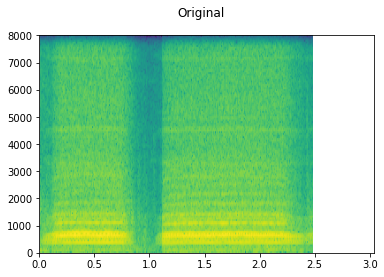

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


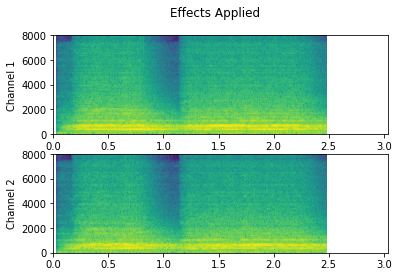

In [ ]:
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)

Simulating room reverberation
----------------------------

`Convolution
reverb <https://en.wikipedia.org/wiki/Convolution_reverb>`__ is a
technique that's used to make clean audio sound as though it has been
produced in a different environment.

Using Room Impulse Response (RIR), for instance, we can make clean speech
sound as though it has been uttered in a conference room.

For this process, we need RIR data. The following data are from the VOiCES
dataset, but you can record your own — just turn on your microphone
and clap your hands.




In [5]:
sample_rate = 8000

rir_raw, _ = get_rir_sample(resample=sample_rate)

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)

NameError: ignored

First, we need to clean up the RIR. We extract the main impulse, normalize
the signal power, then flip along the time axis.




In [ ]:
rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir, [1])

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)

Then, we convolve the speech signal with the RIR filter.




In [ ]:
speech, _ = get_speech_sample(resample=sample_rate)

speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)

Adding background noise
-----------------------

To add background noise to audio data, you can simply add a noise Tensor to
the Tensor representing the audio data. A common method to adjust the
intensity of noise is changing the Signal-to-Noise Ratio (SNR).
[`wikipedia <https://en.wikipedia.org/wiki/Signal-to-noise_ratio>`__]

\begin{align}\mathrm{SNR} = \frac{P_\mathrm{signal}}{P_\mathrm{noise}}\end{align}

\begin{align}{\mathrm  {SNR_{{dB}}}}=10\log _{{10}}\left({\mathrm  {SNR}}\right)\end{align}




In [ ]:
sample_rate = 8000
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
  snr = math.exp(snr_db / 10)
  scale = snr * noise_power / speech_power
  noisy_speech = (scale * speech + noise) / 2

  plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  play_audio(noisy_speech, sample_rate)

Applying codec to Tensor object
-------------------------------

``torchaudio.functional.apply_codec`` can apply codecs to a Tensor object.

**Note** This process is not differentiable.




In [ ]:
waveform, sample_rate = get_speech_sample(resample=8000)

plot_specgram(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

configs = [
    ({"format": "wav", "encoding": 'ULAW', "bits_per_sample": 8}, "8 bit mu-law"),
    ({"format": "gsm"}, "GSM-FR"),
    ({"format": "mp3", "compression": -9}, "MP3"),
    ({"format": "vorbis", "compression": -1}, "Vorbis"),
]
for param, title in configs:
  augmented = F.apply_codec(waveform, sample_rate, **param)
  plot_specgram(augmented, sample_rate, title=title)
  play_audio(augmented, sample_rate)

Simulating a phone recoding
---------------------------

Combining the previous techniques, we can simulate audio that sounds
like a person talking over a phone in a echoey room with people talking
in the background.




In [ ]:
sample_rate = 16000
speech, _ = get_speech_sample(resample=sample_rate)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

# Apply RIR
rir, _ = get_rir_sample(resample=sample_rate, processed=True)
speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
speech = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_specgram(speech, sample_rate, title="RIR Applied")
play_audio(speech, sample_rate)

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

snr_db = 8
scale = math.exp(snr_db / 10) * noise.norm(p=2) / speech.norm(p=2)
speech = (scale * speech + noise) / 2

plot_specgram(speech, sample_rate, title="BG noise added")
play_audio(speech, sample_rate)

# Apply filtering and change sample rate
speech, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
  speech,
  sample_rate,
  effects=[
      ["lowpass", "4000"],
      ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"],
      ["rate", "8000"],
  ],
)

plot_specgram(speech, sample_rate, title="Filtered")
play_audio(speech, sample_rate)

# Apply telephony codec
speech = F.apply_codec(speech, sample_rate, format="gsm")

plot_specgram(speech, sample_rate, title="GSM Codec Applied")
play_audio(speech, sample_rate)